In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math
pd.options.mode.chained_assignment = None  # default='warn'
from definitions import ROOT_DIR
%cd $ROOT_DIR


/home/x/doc/dev/master/CancerTherapyPrediction


przepisać równanie ribby
skopiować dane ribby dotyczące chorych

In [8]:

# df =  pd.read_csv('data/fig1_mtd_pcv_00.csv',names = ['t','mtd','id'],header=None)

df =  pd.read_csv('data/ribba/fig1_mtd_pcv_00.csv',names = ['t','mtd','id'])
df1 = pd.read_csv('data/ribba/fig1_mtd_pcv_01.csv',names = ['t','mtd','id'])
df.id.unique()

array([0, 1, 2, 3])

In [9]:
df1.id.unique()

array([201, 202, 203, 204, 205, 206])

IndexError: index 3 is out of bounds for axis 1 with size 3

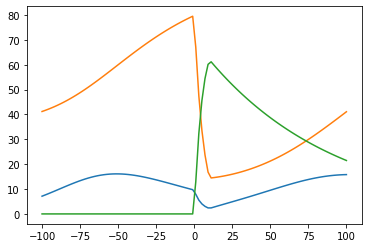

In [12]:
# Ribba
my = RibbaModel(
    lambda_p=0.121,
    delta_qp=  0.00867,
    gamma_q  = 0.729, 
    gamma_p = 0.729,  
    KDE = 0.24, 
    k_qpp = 0.0031, 
    k_pq = 0.0295, 
    K = 100.0 
)

t = np.linspace(-100,100,100)
y = my.run(
    t =t,
    P=7.13,
    Q=41.2,
    Q_p=0.0,
    C=0.0
)

plt.plot(t,y[:,0],label="P")
plt.plot(t,y[:,1],label="Q")
plt.plot(t,y[:,2],label="Q_p")
plt.plot(t,y[:,3],label="C")


plt.legend(loc="upper left")
for i in df.id.unique():
    patient = df[df.id ==i]
    plt.scatter(patient.t,patient.mtd)

plt.xlabel("time [months]")
plt.ylabel("mtd [mm]")

plt.show()

In [11]:
class RibbaModel():

    def __init__(self,lambda_p,delta_qp,gamma_q,gamma_p,KDE,k_qpp,k_pq,K):
        self.lambda_p = lambda_p # the rate constant of growth used in the logistic expression for the expansion of proliferative tissue. Tumor specific
        self.delta_qp = delta_qp  # rate constant for elimination of the damaged quiescent tissue.
        self.gamma_q =gamma_q # damages in quiescent tissue. Treatment specific
        self.gamma_p =gamma_p # damages in proliferative tissue. Treatment specific
        self.KDE = KDE # KDE is the rate constant for the decay of the PCV concentration in plasma, denoted C.
        self.k_qpp =k_qpp # the rate constant for transfer from damaged quiescent tissue to proliferative tissue,
        self.k_pq = k_pq # the rate constant for transition from proliferation to quiescence. Tumor specific
        self.K =K # fixed maximal tumor size 100 mm 
        
    def run(self,t,P,Q,Q_p,C):
        
        y = odeint(RibbaModel.equations,[P,Q,Q_p],t,args=(self.lambda_p,self.delta_qp,self.gamma_q,self.gamma_p,self.KDE,self.k_qpp,self.k_pq,self.K))
        return y
    
    
    """
    P  #proliferative tissue
    C  #drug concentration in plasma
    Q_p =  damaged quiescent tissue
    Q     quiescent tissue
    """
    @staticmethod
    def equations(y,t,lambda_p,delta_qp,gamma_q,gamma_p,KDE,k_qpp,k_pq,K):
        [P,Q, Q_p] = y
        
        
        if t<0:
            C=0.0
        elif t>0 and t<10:
            C=1.0
        else:
            C=0.0
            

        dCdt = - KDE * C
        dPdt = lambda_p * P*(1 - (P + Q + Q_p)/K) + k_qpp * Q_p - k_pq * P - gamma_p * C * KDE * P
        dQdt = k_pq * P - gamma_q * C * KDE * Q
        dQ_pdt = gamma_q * C *KDE * Q - k_qpp * Q_p - delta_qp * Q_p
        return [dPdt,dQdt,dQ_pdt]

Text(0, 0.5, 'mtd [mm]')

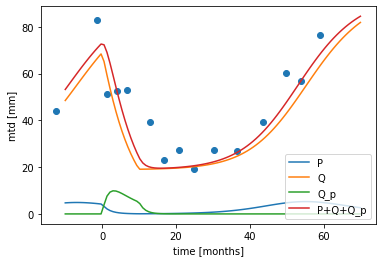

In [13]:
# dr Siwik


def to_volume(mtd):
    return math.pi * mtd**3/6


def preprocess(mtd):
    val = to_volume(mtd)
    return val/1500

my = RibbaModel(
    lambda_p=0.6326,
    delta_qp=  0.6455,
    gamma_q  = 1.3495, 
    gamma_p = 4.6922,  
    KDE = 0.10045, 
    k_qpp = 0.0,
    k_pq = 0.43562,
    K = 192.418
)

t = np.linspace(-10,70,100)
y = my.run(
    t =t,
    P=4.7279,
    Q=48.5147,
    Q_p=0.0,
    C=0.0
)
P = y[:,0]
Q = y[:,1]
Q_p = y[:,2]


plt.plot(t,y[:,0],label="P")
plt.plot(t,y[:,1],label="Q")
plt.plot(t,y[:,2],label="Q_p")
plt.plot(t,P+Q+Q_p, label="P+Q+Q_p")
plt.legend(loc="lower right")


df4 = pd.read_csv('data/ribba/fig4.csv',names = ['t','mtd','id'])
patient = df4[df4.id ==2]
# display(patient)
patient['mtd'] = patient['mtd'].map(lambda x: preprocess(x))
# display(patient)

plt.scatter(patient.t,patient.mtd)


plt.xlabel("time [months]")
plt.ylabel("mtd [mm]")

#plt.show()

In [14]:

mtd = P+Q+Q_p  #TODO: check

df_gen = pd.DataFrame({'t' :t,'mtd' :mtd})
display(df_gen)
df_gen.to_csv('data/ribba/out/gen.csv',index=False)

df_gen = pd.read_csv('data/ribba/out/gen.csv')


,t,mtd
0,-10.000000,53.242600
1,-9.191919,54.993816
2,-8.383838,56.745599
3,-7.575758,58.489580
4,-6.767677,60.217639
...,...,...
95,66.767677,81.050044
96,67.575758,82.019317
97,68.383838,82.925604
98,69.191919,83.771377


## Multiple drug application

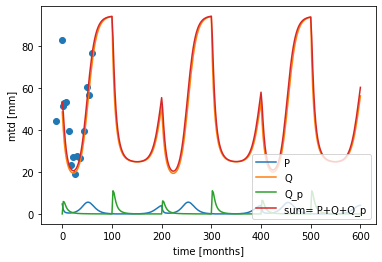

In [7]:
class RibbaModel():

    def __init__(self,lambda_p,delta_qp,gamma_q,gamma_p,KDE,k_qpp,k_pq,K):
        self.lambda_p = lambda_p # the rate constant of growth used in the logistic expression for the expansion of proliferative tissue. Tumor specific
        self.delta_qp = delta_qp  # rate constant for elimination of the damaged quiescent tissue.
        self.gamma_q =gamma_q # damages in quiescent tissue. Treatment specific
        self.gamma_p =gamma_p # damages in proliferative tissue. Treatment specific
        self.KDE = KDE # KDE is the rate constant for the decay of the PCV concentration in plasma, denoted C.
        self.k_qpp =k_qpp # the rate constant for transfer from damaged quiescent tissue to proliferative tissue,
        self.k_pq = k_pq # the rate constant for transition from proliferation to quiescence. Tumor specific
        self.K =K # fixed maximal tumor size 100 mm 
        
    def run(self,P,Q,Q_p):
        okresy = []
        okresy.append({"start": 0, "end" :100})
        okresy.append({"start": 100, "end" :200})
        okresy.append({"start": 200, "end" :300})
        okresy.append({"start": 300, "end" :400})
        okresy.append({"start": 400, "end" :500})
        okresy.append({"start": 500, "end" :600})

        y_sum = np.empty((0,4))
        t_sum = np.empty((0))

        for okres in okresy:
            t = np.linspace(okres["start"],okres["end"])
            t_sum =np.concatenate((t_sum,t))
        # solve ODE
            C =1
            y = odeint(RibbaModel.equations,[P,Q,Q_p,C],t,args=(self.lambda_p,self.delta_qp,self.gamma_q,self.gamma_p,self.KDE,self.k_qpp,self.k_pq,self.K))
            y_sum = np.vstack((y_sum,y))
            P = y[-1,0]
            Q = y[-1,1]
            Q_p = y[-1,2]
            # C = y[:-1,3]


        return (t_sum,y_sum)

    @staticmethod
    def equations(y,t,lambda_p,delta_qp,gamma_q,gamma_p,KDE,k_qpp,k_pq,K):
        [P,Q, Q_p,C] = y

        dCdt = - KDE * C
        dPdt = lambda_p * P*(1 - (P + Q + Q_p)/K) + k_qpp * Q_p - k_pq * P - gamma_p * C * KDE * P
        dQdt = k_pq * P - gamma_q * C * KDE * Q
        dQ_pdt = gamma_q * C *KDE * Q - k_qpp * Q_p - delta_qp * Q_p

        # print(t,y[3])

        return [dPdt,dQdt,dQ_pdt,dCdt]

def to_volume(mtd):
    return math.pi * mtd**3/6


def preprocess(mtd):
    val = to_volume(mtd)
    return val/1500

my = RibbaModel(
    lambda_p=0.6326,
    delta_qp=  0.6455,
    gamma_q  = 1.3495,
    gamma_p = 4.6922,
    KDE = 0.10045,
    k_qpp = 0.0,
    k_pq = 0.43562,
    K = 192.418
)

y = my.run(
    P=4.7279,
    Q=48.5147,
    Q_p=0.0,
)
t, y = y
P = y[:,0]
Q = y[:,1]
Q_p = y[:,2]


plt.plot(t,P,label="P")
plt.plot(t,Q,label="Q")
plt.plot(t,Q_p,label="Q_p")
plt.plot(t,P+Q+Q_p, label="sum= P+Q+Q_p")
plt.legend(loc="lower right")


df4 = pd.read_csv(f'{ROOT_DIR}/data/ribba/fig4.csv',names = ['t','mtd','id'])
patient = df4[df4.id ==2]
# display(patient)
patient['mtd'] = patient['mtd'].map(lambda x: preprocess(x))
# display(patient)

plt.scatter(patient.t,patient.mtd)


plt.xlabel("time [months]")
plt.ylabel("mtd [mm]")

plt.show()

In [ ]:
P0 = 0.1*list(patient.mtd)[0]
Q0 = 0.9*list(patient.mtd)[0]
Q_p0 = 0.0 # We assumed Q_p0 = 0 when t=0 in the absence of treatment.
C =1.0 #??

t = np.linspace(-100,100,100)

y = odeint(model,[P0,Q0,Q_p0,C],t)

# print(y)

print(y[:,0])
plt.scatter(list(patient.t),list(patient.mtd))
plt.plot(t,y)

In [ ]:
# df = df.sort(t)
patient = df[df.id ==1]
list(patient.t)[0]

In [ ]:
#(Simplex, 3Dvar, ABC-SMC),

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.factory import get_problem
from pymoo.optimize import minimize

import numpy as np
from pymoo.core.problem import ElementwiseProblem

class MyProblem(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=2,
                         xl=np.array([-2,-2]),
                         xu=np.array([2,2]))

    def _evaluate(self, x, out, *args, **kwargs):
        f1 = 100 * (x[0]**2 + x[1]**2)
        f2 = (x[0]-1)**2 + x[1]**2

        g1 = 2*(x[0]-0.1) * (x[0]-0.9) / 0.18
        g2 = - 20*(x[0]-0.4) * (x[0]-0.6) / 4.8

        out["F"] = [f1, f2]
        out["G"] = [g1, g2]


problem = MyProblem()


algorithm = NSGA2(pop_size=100)

res = minimize(problem,
               algorithm,
               ('n_gen', 10),
               seed=1,
               verbose=True)

# calculate a hash to show that all executions end with the same result
print("hash", res.F.sum())
